### HYPOTHESIS 1 : The delivery time is high in the Evening's compared to the other part of the day ( Like Morning, Afternoon, Night).

In [1]:
import pandas as pd
import numpy as np
extracted_dir = 'food_delivery_dataset'
csv_file_path = f"{extracted_dir}/train.csv"
df = pd.read_csv(csv_file_path)

print(df.head())

        ID Delivery_person_ID Delivery_person_Age Delivery_person_Ratings  \
0  0x4607     INDORES13DEL02                   37                     4.9   
1  0xb379     BANGRES18DEL02                   34                     4.5   
2  0x5d6d     BANGRES19DEL01                   23                     4.4   
3  0x7a6a    COIMBRES13DEL02                   38                     4.7   
4  0x70a2     CHENRES12DEL01                   32                     4.6   

   Restaurant_latitude  Restaurant_longitude  Delivery_location_latitude  \
0            22.745049             75.892471                   22.765049   
1            12.913041             77.683237                   13.043041   
2            12.914264             77.678400                   12.924264   
3            11.003669             76.976494                   11.053669   
4            12.972793             80.249982                   13.012793   

   Delivery_location_longitude  Order_Date Time_Orderd Time_Order_picked  \
0   

In [2]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45593 entries, 0 to 45592
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           45593 non-null  object 
 1   Delivery_person_ID           45593 non-null  object 
 2   Delivery_person_Age          45593 non-null  object 
 3   Delivery_person_Ratings      45593 non-null  object 
 4   Restaurant_latitude          45593 non-null  float64
 5   Restaurant_longitude         45593 non-null  float64
 6   Delivery_location_latitude   45593 non-null  float64
 7   Delivery_location_longitude  45593 non-null  float64
 8   Order_Date                   45593 non-null  object 
 9   Time_Orderd                  45593 non-null  object 
 10  Time_Order_picked            45593 non-null  object 
 11  Weatherconditions            45593 non-null  object 
 12  Road_traffic_density         45593 non-null  object 
 13  Vehicle_conditio

In [3]:
df["order_time"] = df["Order_Date"] + " " + df["Time_Orderd"]
df["order_pickup_time"] = df["Order_Date"] + " " + df["Time_Order_picked"]

# Step 2: Converting the columns to datetime
df["order_time"] = pd.to_datetime(df["order_time"], format="%d-%m-%Y %H:%M:%S", errors="coerce")
df["order_pickup_time"] = pd.to_datetime(df["order_pickup_time"], format="%d-%m-%Y %H:%M:%S", errors="coerce")

Fill Na values with the mean of the data

In [4]:
mean_order_time = df["order_time"].mean()
mean_order_pickup_time = df["order_pickup_time"].mean()
df["order_time"] = df["order_time"].fillna(mean_order_time)
df["order_pickup_time"] = df["order_pickup_time"].fillna(mean_order_pickup_time)

Convert Time_taken to numeric and split by (min) to convert the column to only time

In [5]:
def extract_time_taken(value):
    time_strings = value.split('(min) ')
    return [float(time) for time in time_strings if time.isdigit()]

Fill the null values of time_taken(min) with mean of the time

In [6]:
df["time_taken_min"] = df["Time_taken(min)"].apply(lambda x: extract_time_taken(x) if isinstance(x, str) else [])

df_exploded = df.explode('time_taken_min')
mean_time_taken = df_exploded['time_taken_min'].mean()

Print new columns of order_time, pickup_time and time taken 

In [7]:
df["time_taken_min"] = df["time_taken_min"].apply(lambda x: x if len(x) > 0 else mean_time_taken)
df["time_taken_min"] = df["time_taken_min"].apply(lambda x: x[0] if isinstance(x, list) else x)

df['Waiting_Time(min)'] = (df['order_pickup_time'] - df['order_time']).dt.total_seconds() / 60
print(df[["order_time", "order_pickup_time", "time_taken_min"]].head())

           order_time   order_pickup_time  time_taken_min
0 2022-03-19 11:30:00 2022-03-19 11:45:00            24.0
1 2022-03-25 19:45:00 2022-03-25 19:50:00            33.0
2 2022-03-19 08:30:00 2022-03-19 08:45:00            26.0
3 2022-04-05 18:00:00 2022-04-05 18:10:00            21.0
4 2022-03-26 13:30:00 2022-03-26 13:45:00            30.0


Categorize the time into 4 quarters Morning, Afternoon, Evening, Night

In [8]:
df['Order_hour'] = df['order_time'].dt.hour

def categorize_time_of_day(hour):
    if 5 <= hour < 11:
        return 'Morning'
    elif 11 <= hour < 16:
        return 'Afternoon'
    elif 16 <= hour < 20:
        return 'Evening'
    else:
        return 'Night'

df['Part_of_Day'] = df['Order_hour'].apply(categorize_time_of_day)

print(df[['Order_hour', 'Part_of_Day']].head())


   Order_hour Part_of_Day
0          11   Afternoon
1          19     Evening
2           8     Morning
3          18     Evening
4          13   Afternoon


Group data into parts of the day and calculate average delivery time

In [9]:
avg_delivery_time_by_part_of_day = df.groupby('Part_of_Day')['time_taken_min'].mean().reset_index()
print("Average Delivery Time by Part of Day:")
print(avg_delivery_time_by_part_of_day)


Average Delivery Time by Part of Day:
  Part_of_Day  time_taken_min
0   Afternoon       26.274802
1     Evening       28.255867
2     Morning       21.102578
3       Night       26.902785


Print the statistics like mean, median, and then standard deviation.

In [10]:
# Step 1: Create a new column for the hour of the order time
df['Order_hour'] = df['order_time'].dt.hour

# Step 2: Calculate summary statistics (mean, median, std) for delivery time
summary_stats = df.groupby('Order_hour')['time_taken_min'].agg(['mean', 'median', 'std']).reset_index()
print("Summary Statistics of Delivery Time by Hour:")
print(summary_stats)

Summary Statistics of Delivery Time by Hour:
    Order_hour       mean  median        std
0            0  22.169767    21.0   7.201497
1            8  19.584158    19.0   5.630408
2            9  19.543914    19.0   5.520633
3           10  22.659592    21.0   8.430848
4           11  26.380734    27.0   8.251917
5           12  26.826233    27.0   8.642940
6           13  27.538265    27.0   8.574879
7           14  27.537295    27.0   8.346503
8           15  23.194731    23.0   6.925132
9           16  22.943583    24.0   6.921038
10          17  27.406732    27.0   8.582765
11          18  27.274777    27.0   8.705147
12          19  30.822633    30.0   9.824521
13          20  31.190350    31.0   9.941206
14          21  31.089842    31.0  10.022804
15          22  23.196241    22.0   7.900360
16          23  22.450233    22.0   7.338967


Calculate the Variance, Standard deviation and Interquartile range for the time_taken

In [11]:
variance_time_taken = df['time_taken_min'].var()
std_dev_time_taken = df['time_taken_min'].std()
IQR_time_taken = df['time_taken_min'].quantile(0.75) - df['time_taken_min'].quantile(0.25)

print(f"Variance of time taken: {variance_time_taken:.2f}")
print(f"Standard deviation of time taken: {std_dev_time_taken:.2f}")
print(f"IQR of time taken: {IQR_time_taken:.2f}")


Variance of time taken: 88.06
Standard deviation of time taken: 9.38
IQR of time taken: 13.00


Plot the graph between average delivery time by part of day

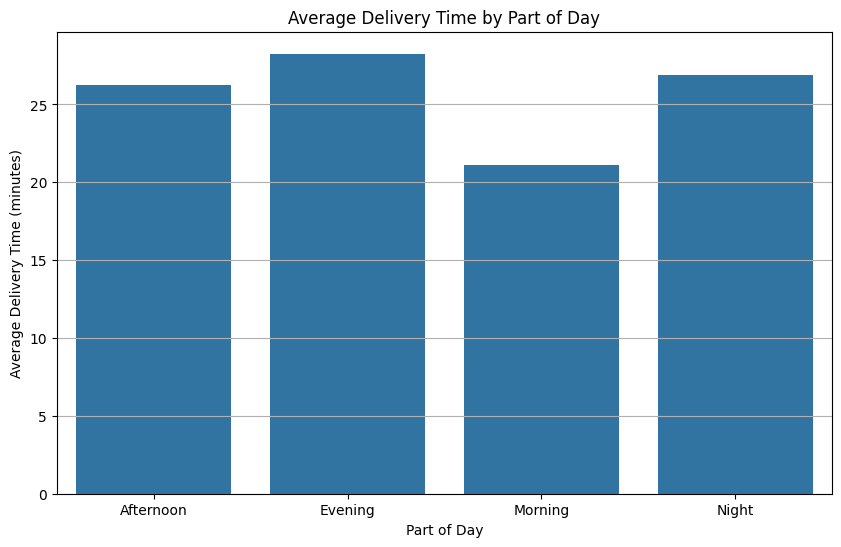

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(data=avg_delivery_time_by_part_of_day, x='Part_of_Day', y='time_taken_min')
plt.title('Average Delivery Time by Part of Day')
plt.xlabel('Part of Day')
plt.ylabel('Average Delivery Time (minutes)')
plt.grid(axis='y')
plt.show()


Bar plot of average delivery time by part of day that is four quarters. It is clear seen that the average delivery time is high in the evening and night whereas the delivery time is less in the morning compared to other. The delivery time for all the parts are some kind of similar with nothing much difference. The average delivery time is around 23 minutes.


C:\Users\upata\AppData\Local\Temp\ipykernel_5104\922707435.py:7: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data_part_of_day = df.pivot_table(


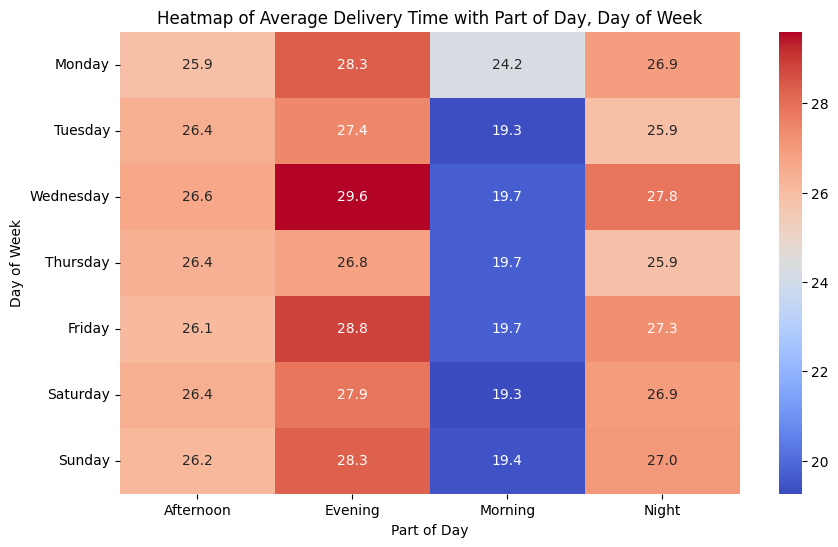

In [13]:
df['Order_day'] = df['order_time'].dt.day_name()

day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

df['Order_day'] = pd.Categorical(df['Order_day'], categories=day_order, ordered=True)

heatmap_data_part_of_day = df.pivot_table(
    values='time_taken_min', 
    index='Order_day', 
    columns='Part_of_Day', 
    aggfunc='mean'
)

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data_part_of_day, annot=True, fmt=".1f", cmap='coolwarm')
plt.title('Heatmap of Average Delivery Time with Part of Day, Day of Week')
plt.xlabel('Part of Day')
plt.ylabel('Day of Week')
plt.show()

The heat map between the Average delivery time and and day of the week, part of the day. It is clear that on wednesday evening the delivery time is high and in the morning the time is less for all days of the week.

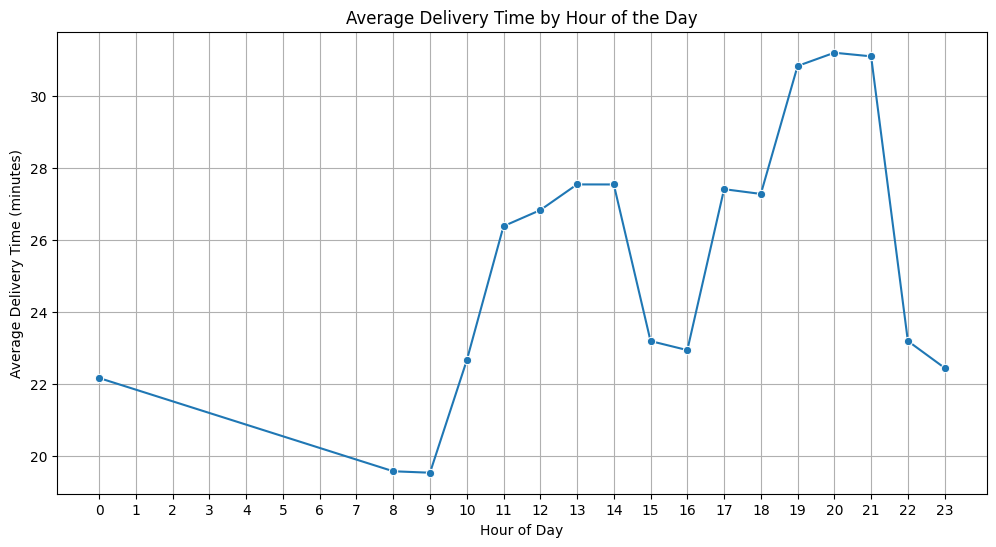

In [14]:
avg_delivery_time_by_hour = df.groupby('Order_hour')['time_taken_min'].mean().reset_index()
plt.figure(figsize=(12, 6))
sns.lineplot(data=avg_delivery_time_by_hour, x='Order_hour', y='time_taken_min', marker='o')
plt.title('Average Delivery Time by Hour of the Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Delivery Time (minutes)')
plt.xticks(range(24))
plt.grid()
plt.show()


The graph shows the average delivery time by hour of day. It starts with 12AM the delivery time reduces till 9AM in the morning and then gradually increases till 2PM then decreases a bit and then increases till 9PM. After that it decreases. Which repeats again, the hour of the day with least delivery time is between 8AM-9AM. And highest is 8PM-9PM

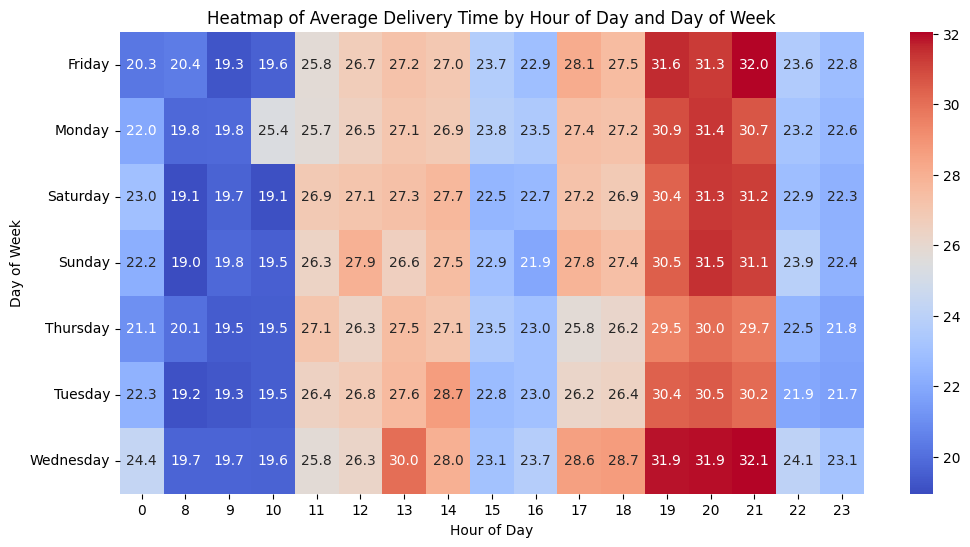

In [15]:
df['Order_day'] = df['order_time'].dt.day_name()

heatmap_data = df.pivot_table(values='time_taken_min', index='Order_day', columns='Order_hour', aggfunc='mean')
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap='coolwarm')
plt.title('Heatmap of Average Delivery Time by Hour of Day and Day of Week')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.show()


The heatmap is for the average delievry time by hour of day and day of week. Between the timings 7PM-9PM all the days the bdelivery time is high. And between 8AM-10AM the delivery time is very less. 

In [16]:
df['Waiting_Time_Range'] = pd.cut(
    df['Waiting_Time(min)'], 
    bins=[0, 5, 10, 15, 20, 30, df['Waiting_Time(min)'].max() + 1],
    labels=['0-5', '5-10', '10-15', '15-20', '20-30', '30+'],
    right=True
)
avg_delivery_time = df.groupby('Waiting_Time_Range')['time_taken_min'].mean().reset_index()

C:\Users\upata\AppData\Local\Temp\ipykernel_5104\1756604696.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_delivery_time = df.groupby('Waiting_Time_Range')['time_taken_min'].mean().reset_index()


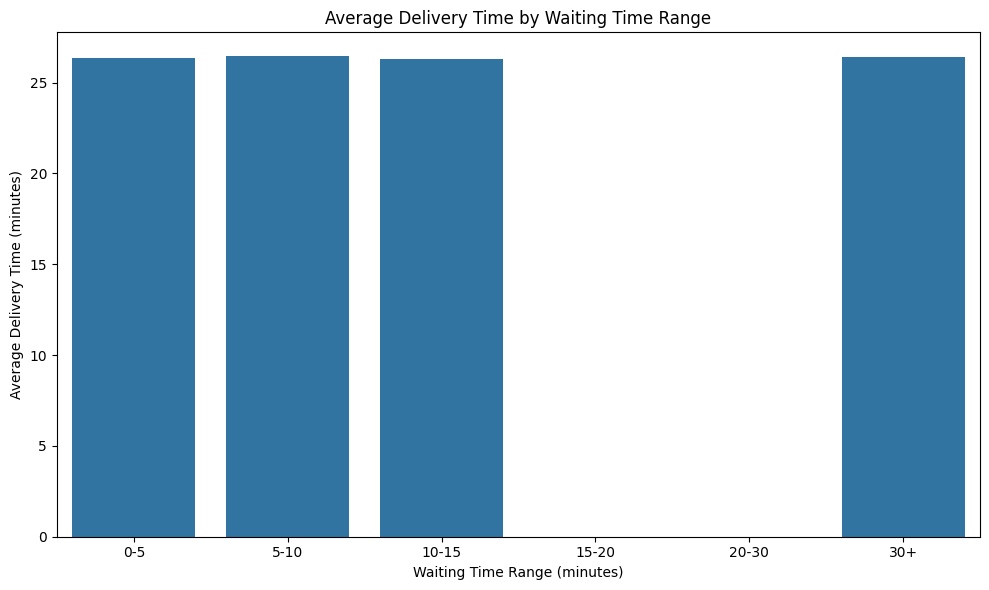

In [17]:
plt.figure(figsize=(10, 6))
sns.barplot(data=avg_delivery_time, x='Waiting_Time_Range', y='time_taken_min')
plt.title('Average Delivery Time by Waiting Time Range')
plt.xlabel('Waiting Time Range (minutes)')
plt.ylabel('Average Delivery Time (minutes)')
plt.tight_layout()
plt.show()

The bar graph is between average delivery time and waiting range. There is nothing much difference between the delivery time for various waiting time ranges. And there is no delivery time groups between the waiting time intervals 15-30.

In [18]:
correlation = df['Waiting_Time(min)'].corr(df['time_taken_min'])

print(f"Correlation between Waiting Time and Delivery Time: {correlation:.4f}")

Correlation between Waiting Time and Delivery Time: 0.0005


The correlation is very less for the waiting time and delivery time indicating that they are least correlated.

### HYPOTHESIS-2 : The order preparation time for the drinks is less compared to other type of orders.

Drop the time ordered and picked columns with containing null values

In [19]:
df['Time_Orderd'] = pd.to_datetime(df['Time_Orderd'], format='%H:%M:%S', errors='coerce')
df['Time_Order_picked'] = pd.to_datetime(df['Time_Order_picked'], format='%H:%M:%S', errors='coerce')

Calculate wait time and calculate average waiting time for various types of orders.

In [20]:
df['Wait_Time(min)'] = (pd.to_datetime(df['Time_Orderd']) - pd.to_datetime(df['Time_Order_picked'])).dt.total_seconds() / 60
avg_waiting_time_by_order_type = df.groupby('Type_of_order')['Wait_Time(min)'].mean()
print(avg_waiting_time_by_order_type)

Type_of_order
Buffet     17.563559
Drinks     12.507112
Meal       17.486840
Snack      21.535930
Name: Wait_Time(min), dtype: float64


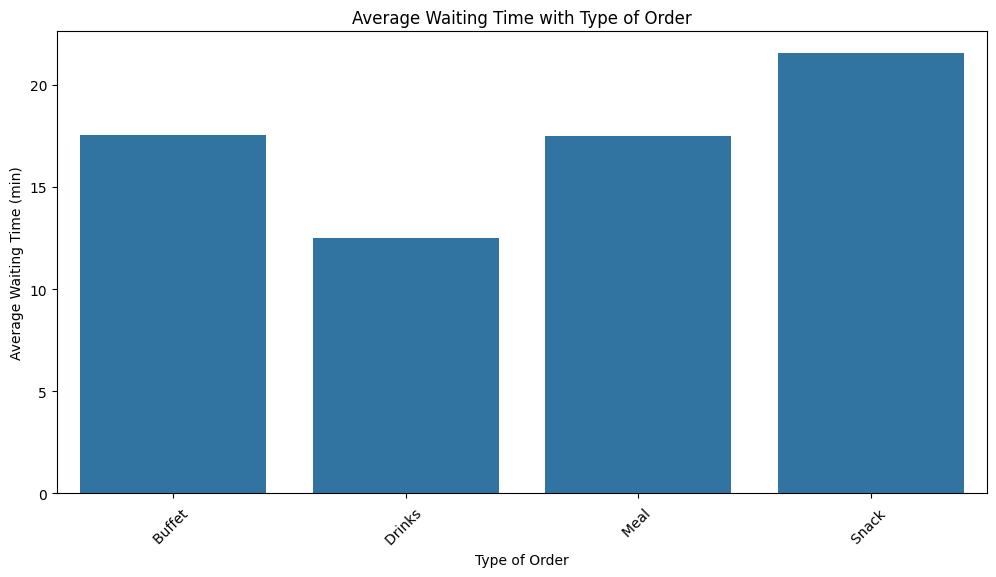

In [21]:
plt.figure(figsize=(12, 6))
sns.barplot(x=avg_waiting_time_by_order_type.index, y=avg_waiting_time_by_order_type.values)
plt.title('Average Waiting Time with Type of Order')
plt.xlabel('Type of Order')
plt.ylabel('Average Waiting Time (min)')
plt.xticks(rotation=45)
plt.show()

By observing the above bar graph we can see that the preparation or waiting time for order to get picked is less for the drinks whereas the preparation time for the snacks is high compared to other order types such as Buffet, Meal.

Calculate mean and median waiting times for various types of orders.


In [22]:
mean_wait_time = df.groupby('Type_of_order')['Wait_Time(min)'].mean()
median_wait_time = df.groupby('Type_of_order')['Wait_Time(min)'].median()

print("Mean Waiting Time by Type of Order:\n", mean_wait_time)
print("Median Waiting Time by Type of Order:\n", median_wait_time)

Mean Waiting Time by Type of Order:
 Type_of_order
Buffet     17.563559
Drinks     12.507112
Meal       17.486840
Snack      21.535930
Name: Wait_Time(min), dtype: float64
Median Waiting Time by Type of Order:
 Type_of_order
Buffet    -10.0
Drinks    -10.0
Meal      -10.0
Snack     -10.0
Name: Wait_Time(min), dtype: float64


Create a column to find the day of the week and then calculate hte average waiting time by type of order and day of the week, and then draw the heap map. 

C:\Users\upata\AppData\Local\Temp\ipykernel_5104\557280768.py:1: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Order_Date'] = pd.to_datetime(df['Order_Date'])


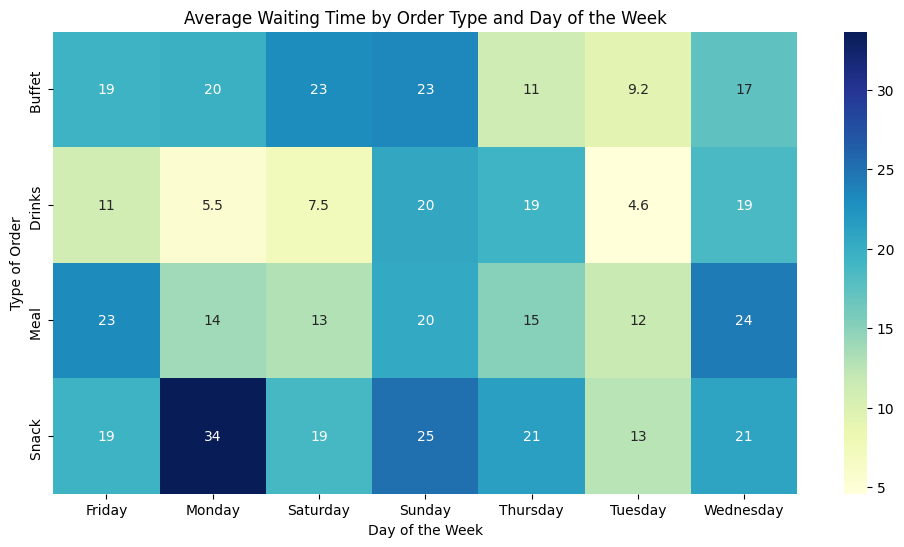

In [23]:
df['Order_Date'] = pd.to_datetime(df['Order_Date'])
df['Day_of_Week'] = df['Order_Date'].dt.day_name()

avg_wait_time_heatmap = df.groupby(['Type_of_order', 'Day_of_Week'])['Wait_Time(min)'].mean().unstack()

plt.figure(figsize=(12, 6))
sns.heatmap(avg_wait_time_heatmap, annot=True, cmap='YlGnBu')
plt.title('Average Waiting Time by Order Type and Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Type of Order')
plt.show()


The heatmap shows the average waiting time with order type and day of the week. The key observations are Snacks ordered more on monday morning. Overall Meals are ordered more compared to other order types. On sunday he orders are high and on tuesday there are less. Drinks are ordered less on all the days.